# Modelo de regresión
1. Transformar el csv 0 - 1
2. Obtener imagenes
3. Crear valores Y para cada imagen
4. Crear el modelo
5. Entrenar el modelo
6. Comparar resultados

## 1. Transformar csv 0 - 1

In [2]:
from google.colab import drive
import pandas as pd
import numpy as np
drive.mount('/content/drive',)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
drive_path = '/content/drive/Shareddrives/Data Science Proyecto 2/DataSets'

df = pd.read_csv( drive_path + '/train.csv')
df.head()

,filename,growth_stage,damage,extent,season
0,L398F01276C01S07896Rp26856.jpg,F,DR,0,LR2021
1,L355F02268C02S08916Rp30595.jpg,F,DR,0,LR2021
2,L134F00879C39S14248Rp42482.jpg,F,DR,10,SR2021
3,L1095F01359C01S08260Rp24587.jpg,F,DR,10,LR2021
4,L134F00777C39S14171Rp45993.jpg,F,DR,10,SR2021


In [4]:
df['extent'] = df['extent'].astype(int)/100.0
df.head()

,filename,growth_stage,damage,extent,season
0,L398F01276C01S07896Rp26856.jpg,F,DR,0.0,LR2021
1,L355F02268C02S08916Rp30595.jpg,F,DR,0.0,LR2021
2,L134F00879C39S14248Rp42482.jpg,F,DR,0.1,SR2021
3,L1095F01359C01S08260Rp24587.jpg,F,DR,0.1,LR2021
4,L134F00777C39S14171Rp45993.jpg,F,DR,0.1,SR2021


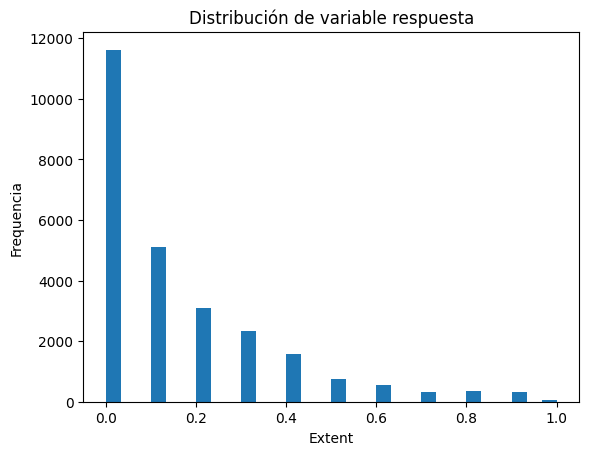

In [5]:
import matplotlib.pyplot as plt

plt.hist(df['extent'], bins=30)
plt.title('Distribución de variable respuesta')
plt.xlabel('Extent')
plt.ylabel('Frequencia')
plt.show()

In [6]:
df['extent'].describe()

count    26106.000000
mean         0.153796
std          0.204993
min          0.000000
25%          0.000000
50%          0.100000
75%          0.200000
max          1.000000
Name: extent, dtype: float64

In [7]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import shutil


image_dir = drive_path + '/train'

## Obtener imágenes

In [10]:
import pathlib

# Create a Path object for the directory
dir_path = pathlib.Path(image_dir)

# Use glob to list all files in the directory
files = list(dir_path.glob('*.*'))

# Count the number of files
file_count = len(files)

print("Number of files in the directory:", file_count)

Number of files in the directory: 19292


In [11]:
img_height=64
img_width=64
batch_size=32

train_ds = tf.keras.utils.image_dataset_from_directory(
  image_dir,
  seed=123,
  image_size=(img_height, img_width),
  validation_split=0.2,
  subset="training",
  batch_size=batch_size)

Found 19289 files belonging to 11 classes.
Using 15432 files for training.


In [16]:
y_train = []
for _, labels in train_ds: y_train.extend(labels.numpy())


In [17]:
from sklearn.utils.class_weight import compute_class_weight
class_weights_222 = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights_222))

In [18]:
categories_count = np.zeros(len(train_ds.class_names), dtype=int)

for _, labels in train_ds:
    unique, count = np.unique(labels.numpy(), return_counts=True)
    categories_count[unique] += count

total = categories_count.sum()

print('Distribution:\n')
for categorie, count in enumerate(categories_count):
    class_name = train_ds.class_names[categorie]
    print(f'{class_name}: {count} ({100 * count / total:.2f}%)')


Distribution:

0: 6840 (44.32%)
1: 3034 (19.66%)
10: 27 (0.17%)
2: 1878 (12.17%)
3: 1373 (8.90%)
4: 935 (6.06%)
5: 454 (2.94%)
6: 314 (2.03%)
7: 201 (1.30%)
8: 193 (1.25%)
9: 183 (1.19%)


In [19]:
train_ds_class_names = train_ds.class_names
class_weights = { train_ds_class_names[i]: (1 / count) * (total / 2.0) for i, count in enumerate(categories_count) }

print('Class weights:')
for class_label, weight in class_weights.items(): print(f'Class {class_label}: weight {weight:.3f}')

class_weights = {int(k): v for k, v in class_weights.items()}


Class weights:
Class 0: weight 1.128
Class 1: weight 2.543
Class 10: weight 285.778
Class 2: weight 4.109
Class 3: weight 5.620
Class 4: weight 8.252
Class 5: weight 16.996
Class 6: weight 24.573
Class 7: weight 38.388
Class 8: weight 39.979
Class 9: weight 42.164


In [20]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  image_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 19289 files belonging to 11 classes.
Using 3857 files for validation.


In [32]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping


data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

norm_layer = layers.Rescaling(1./255)
model = tf.keras.Sequential([
    data_augmentation,
    norm_layer,
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='tanh'),
    tf.keras.layers.Dense(1)
])

#early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error',])
history = model.fit(train_ds, epochs=25, validation_data=val_ds, verbose=1, class_weight=class_weights_dict)


Epoch 1/25
483/483 [==============================] - 76s 151ms/step - loss: 10.3464 - mean_squared_error: 15.9588 - mean_absolute_error: 3.5903 - val_loss: 16.0542 - val_mean_squared_error: 16.0542 - val_mean_absolute_error: 3.6203
Epoch 2/25
483/483 [==============================] - 75s 153ms/step - loss: 10.0573 - mean_squared_error: 15.6029 - mean_absolute_error: 3.5717 - val_loss: 16.2647 - val_mean_squared_error: 16.2647 - val_mean_absolute_error: 3.6476
Epoch 3/25
483/483 [==============================] - 75s 153ms/step - loss: 10.1013 - mean_squared_error: 15.5285 - mean_absolute_error: 3.5626 - val_loss: 16.7022 - val_mean_squared_error: 16.7022 - val_mean_absolute_error: 3.7026
Epoch 4/25
483/483 [==============================] - 74s 150ms/step - loss: 10.0632 - mean_squared_error: 15.6535 - mean_absolute_error: 3.5782 - val_loss: 15.4469 - val_mean_squared_error: 15.4469 - val_mean_absolute_error: 3.5407
Epoch 5/25
483/483 [==============================] - 74s 151ms/step

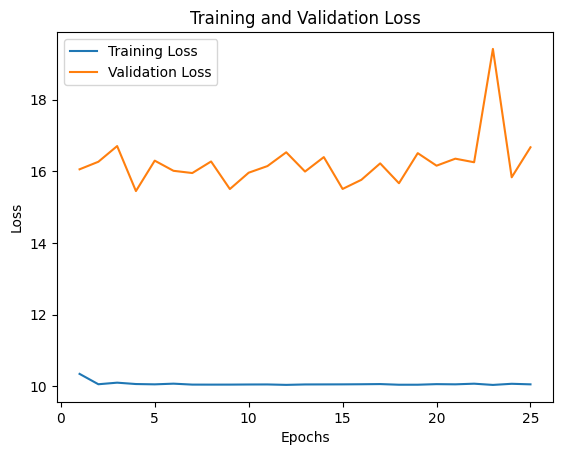

In [33]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


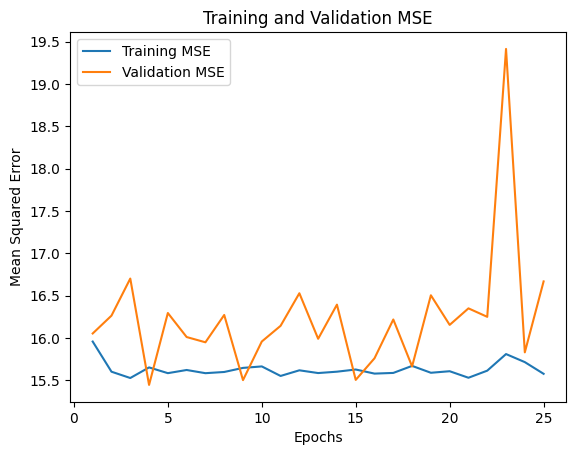

In [34]:
train_mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']
epochs = range(1, len(train_mse) + 1)

plt.plot(epochs, train_mse, label='Training MSE')
plt.plot(epochs, val_mse, label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()

plt.show()


In [35]:
print("Training Loss per Epoch:", train_loss)
print("Validation Loss per Epoch:", val_loss)

Training Loss per Epoch: [10.34640884399414, 10.057313919067383, 10.101295471191406, 10.063163757324219, 10.054652214050293, 10.073471069335938, 10.047327041625977, 10.04670524597168, 10.04728889465332, 10.050387382507324, 10.051734924316406, 10.039742469787598, 10.05168342590332, 10.052851676940918, 10.054120063781738, 10.05725383758545, 10.062118530273438, 10.043669700622559, 10.044065475463867, 10.060263633728027, 10.0549898147583, 10.072808265686035, 10.038472175598145, 10.070060729980469, 10.05444049835205]
Validation Loss per Epoch: [16.054162979125977, 16.26466178894043, 16.70223045349121, 15.446864128112793, 16.295616149902344, 16.01209831237793, 15.949976921081543, 16.27250862121582, 15.5034818649292, 15.959074020385742, 16.14440155029297, 16.529050827026367, 15.99146556854248, 16.394439697265625, 15.50611686706543, 15.761490821838379, 16.21929168701172, 15.665217399597168, 16.504940032958984, 16.155405044555664, 16.350557327270508, 16.250619888305664, 19.412796020507812, 15.8

In [36]:
model_path = 'weighted_categories_model.keras'
model.save(model_path)

In [28]:
import tensorflow as tf

model_path = 'weighted_categories_model.keras'
loaded_model = tf.keras.models.load_model(model_path)

loaded_model.save('weighted_categories_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
from tensorflow.keras.preprocessing import image
import numpy as np

def img_regression(img_dir):
  img_height=64
  img_width=64

  img = tf.expand_dims(
          tf.image.resize(
            tf.image.decode_jpeg(
              tf.io.read_file(img_dir), channels=3), [img_height, img_width]) / 255.0, 0)
  return model.predict(img)


In [37]:
img_dir = '11_repeat_2_2416_5427_3808.JPG'
result = img_regression(img_dir)
print(result)

1/1 [==============================] - 0s 172ms/step
[[5.200368]]
